In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [9]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [8]:
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [4]:
# MNIST IMAGE -> Tensor

In [10]:
transform = transforms.ToTensor()

In [12]:
train_data = datasets.MNIST(root='../Datasets', train=True, download=True, transform=transform)

In [14]:
test_data = datasets.MNIST(root='../Datasets', train=False, download=True, transform=transform)

In [15]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Datasets
    Split: Train
    StandardTransform
Transform: ToTensor()

In [16]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Datasets
    Split: Test
    StandardTransform
Transform: ToTensor()

In [18]:
type(train_data)

torchvision.datasets.mnist.MNIST

In [19]:
train_data[0]

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
           0.0000, 0.0000, 0.0000, 0.0000, 

In [25]:
image, label = train_data[0]
print(image.shape)
print(label)

torch.Size([1, 28, 28])
5


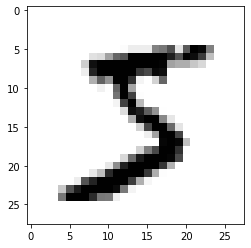

In [29]:
plt.imshow(image.reshape(28,28), cmap='gist_yarg') #viridis

In [30]:
torch.manual_seed(101)

train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=500, shuffle=False)

In [32]:
from torchvision.utils import make_grid

In [33]:
# First batch
for images, labels in train_loader:
    break

In [36]:
images.shape

torch.Size([100, 1, 28, 28])

Labels:  [4 6 2 3 4 0 9 5 0 1 6 9]


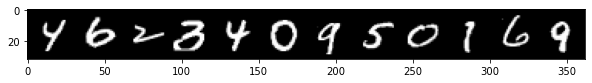

In [37]:
# Print 12 first labels
print('Labels: ', labels[:12].numpy())

# Print 12 first images
im = make_grid(images[:12], nrow=12)
plt.figure(figsize=(10, 4))
# We need too transpose the images for the plt.imshow to understand, from CWH to WHC
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)))

## 2.Creating the network

In [38]:
class MultiLayerPerception(nn.Module):
    def __init__(self, input_sz=784, output_size=10, layers=[120, 84]):
        super().__init__()

        self.fc1 = nn.Linear(input_sz, layers[0])
        self.fc2 = nn.Linear(layers[0], layers[1])
        self.fc3 = nn.Linear(layers[1], output_size)

    def forward(self, X):
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)

        return F.log_softmax(X, dim=1)

In [39]:
torch.manual_seed(101)
model = MultiLayerPerception()
model

MultiLayerPerception(
  (fc1): Linear(in_features=784, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [40]:
# ANN -> CNN:
for param in model.parameters():
    print(param.numel())

94080
120
10080
84
840
10


In [42]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [49]:
images.view(100, -1).shape

torch.Size([100, 784])

## 3. Training and valuating the model

In [51]:
import time 
start_time = time.time()

epochs = 10

train_losses = []
test_losses = []
train_correct = []
test_correct = []

for epoch in range(epochs):
    tr_cor = 0
    te_cor = 0

    for b, (X_train, y_train) in enumerate(train_loader):

        b += 1
        y_pred = model(X_train.view(100, -1))
        loss = criterion(y_pred, y_train)

        predicted = torch.max(y_pred.data, 1)[1]
        batch_cor = (predicted == y_train).sum()
        tr_cor += batch_cor

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%200 == 0:
            accuracy = tr_cor.item() * 100 / (100 * b)
            print(f'Epoch: {epoch}  batch: {b}  loss:{loss.item()}  accuracy: {accuracy}')

    train_losses.append(loss)
    train_correct.append(tr_cor)

    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):
            y_val = model(X_test.view(500, -1))
            predicted = torch.max(y_val.data, 1)[1]
            te_cor += (predicted == y_test).sum()

    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(te_cor  )

total_time = time.time() - start_time
print(f'Durations: {total_time/60} mins')

Epoch: 0  batch: 200  loss:0.1818152219057083  accuracy: 88.195
Epoch: 0  batch: 400  loss:0.09590303152799606  accuracy: 91.48
Epoch: 0  batch: 600  loss:0.1858411729335785  accuracy: 92.65166666666667
Epoch: 1  batch: 200  loss:0.09741141647100449  accuracy: 96.14
Epoch: 1  batch: 400  loss:0.11191572993993759  accuracy: 96.21
Epoch: 1  batch: 600  loss:0.09899833798408508  accuracy: 96.215
Epoch: 2  batch: 200  loss:0.005635796580463648  accuracy: 96.83
Epoch: 2  batch: 400  loss:0.14406898617744446  accuracy: 96.81
Epoch: 2  batch: 600  loss:0.2135297954082489  accuracy: 96.855
Epoch: 3  batch: 200  loss:0.04067814722657204  accuracy: 97.485
Epoch: 3  batch: 400  loss:0.1257389485836029  accuracy: 97.32
Epoch: 3  batch: 600  loss:0.08788121491670609  accuracy: 97.20333333333333
Epoch: 4  batch: 200  loss:0.09423942863941193  accuracy: 97.795
Epoch: 4  batch: 400  loss:0.12291604280471802  accuracy: 97.5475
Epoch: 4  batch: 600  loss:0.08369731903076172  accuracy: 97.47166666666666


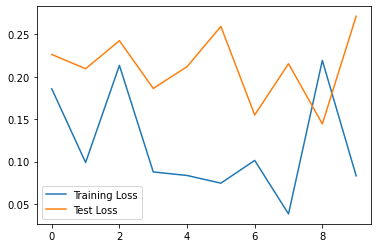

In [55]:
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()

In [60]:
train_acc = [t / 600 for t in train_correct]

In [61]:
train_acc

[tensor(92.6517),
 tensor(96.2150),
 tensor(96.8550),
 tensor(97.2033),
 tensor(97.4717),
 tensor(97.7333),
 tensor(97.8533),
 tensor(98.0017),
 tensor(98.2967),
 tensor(98.3317)]

In [66]:
test_acc = [t / 100 for t in test_correct]

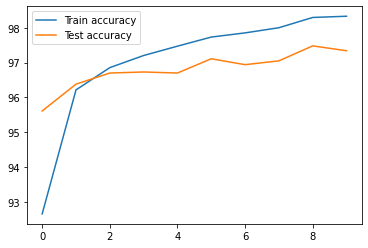

In [67]:
plt.plot(train_acc, label='Train accuracy')
plt.plot(test_acc, label='Test accuracy')
plt.legend()

In [68]:
# New unseen data:

test_load_all = DataLoader(test_data, batch_size=10000, shuffle=True)

In [69]:
with torch.no_grad():
    correct = 0

    for X_test, y_test in test_load_all:
        y_val = model(X_test.view(len(X_test), -1))
        predicted = torch.max(y_val, 1)[1]
        correct += (predicted == y_test).sum()

In [73]:
correct.item() / len(test_data)

0.9734

In [74]:
confusion_matrix(predicted.view(-1), y_test.view(-1))

array([[ 973,    0,    2,    1,    1,    2,    6,    3,    3,    4],
       [   1, 1127,    1,    1,    1,    0,    2,    3,    3,    3],
       [   1,    4, 1000,    8,    6,    0,    5,    7,    6,    0],
       [   1,    0,    5,  986,    0,   22,    3,    3,    5,    8],
       [   0,    0,    2,    0,  944,    1,    2,    0,    1,    7],
       [   0,    0,    0,    2,    0,  850,    3,    0,    0,    3],
       [   0,    1,    2,    0,    3,    5,  933,    0,    3,    0],
       [   1,    1,    6,    3,    6,    0,    0, 1001,    2,    2],
       [   3,    2,   14,    7,    3,    7,    4,    0,  949,   11],
       [   0,    0,    0,    2,   18,    5,    0,   11,    2,  971]],
      dtype=int64)